# SMO algorithm
Here is the [link](https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/tr-98-14.pdf) to the paper

# Getting data

In [1]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from pandas import read_csv
from sklearn.model_selection import KFold
from tqdm.notebook import tqdm
import os

In [13]:
def read_data(filename):
    a = read_csv('data/' + filename)
    return a[['x', 'y']].values.tolist(), [1 if c == 'P' else -1 for c in a['class']]

# Hyperparameter optimization

In [3]:
def get_accuracy_score(y_true, y_predicted):
    return sum(1 if y_true_i == y_predicted_i else 0 for y_true_i, y_predicted_i in zip(y_true, y_predicted)) / len(y_true)

In [5]:
import math
import random
import time

In [6]:
class SVMClassifier:
    kernels = {'linear': lambda x, y, _: sum(xi * yi for xi, yi, in zip(x, y)),
               'polynomial': lambda x, y, d: (sum(xi * yi for xi, yi, in zip(x, y)) + 1) ** d,
               'gaussian': lambda x, y, sigma: math.exp(
                   -math.sqrt(sum((xi - yi) ** 2 for xi, yi in zip(x, y)) ** 2 / (2 * sigma ** 2)))
               }

    def __init__(self, C, kernel, kernel_param=None):
        self.kernel = self.kernels[kernel]
        self.kernel_param = kernel_param
        self.epochs_count = 1000
        self.tolerance = 1e-9
        self.C = C

    def count_lambdas(self, K, y_train):
        lambdas = [0 for _ in range(len(y_train))]
        b = 0
        start_time = time.time()

        def get_prediction(i):
            return sum(yi * lambdas_i * k_i_j for yi, lambdas_i, k_i_j in zip(y_train, lambdas, K[i])) + b

        while time.time() - start_time < 1.5:
            for i in range(len(y_train)):
                E_i = get_prediction(i) - y_train[i]
                j = random.choice([j for j in range(i)] + [j for j in range(i + 1, len(y_train))])
                E_j = get_prediction(j) - y_train[j]

                old_lambda_i = lambdas[i]
                old_lambda_j = lambdas[j]

                if y_train[i] != y_train[j]:
                    L = max(0.0, lambdas[j] - lambdas[i])
                    H = min(self.C, self.C + lambdas[j] - lambdas[i])
                else:
                    L = max(0.0, lambdas[i] + lambdas[j] - self.C)
                    H = min(self.C, lambdas[i] + lambdas[j])

                eta = 2 * K[i][j] - K[i][i] - K[j][j]
                if abs(L - H) < self.tolerance or abs(eta) < self.tolerance:
                    continue

                new_lambda_j = old_lambda_j - y_train[j] * (E_i - E_j) / eta
                new_lambda_j = min(max(new_lambda_j, L), H)
                if abs(new_lambda_j - old_lambda_j) < self.tolerance:
                    continue
                lambdas[j] = new_lambda_j
                lambdas[i] += y_train[i] * y_train[j] * (old_lambda_j - lambdas[j])

                b1 = b - E_i - K[i][i] * y_train[i] * (lambdas[i] - old_lambda_i) - K[i][j] * y_train[j] * (
                        lambdas[j] - old_lambda_j)
                b2 = b - E_j - K[i][j] * y_train[i] * (lambdas[i] - old_lambda_i) - K[j][j] * y_train[j] * (
                        lambdas[j] - old_lambda_j)
                if 0 < lambdas[i] < self.C:
                    b = b1
                elif 0 < lambdas[j] < self.C:
                    b = b2
                else:
                    b = (b1 + b2) / 2
        self.lambdas = lambdas
        self.b = b

    def fit(self, X_train, y_train, epochs_count=100):
        self.epochs_count = epochs_count
        self.X_train = X_train
        self.y_train = y_train
        K = [[self.kernel(x1, x2, self.kernel_param) for x2 in X_train] for x1 in X_train]
        self.count_lambdas(K, y_train)

    def get_params(self):
        return self.lambdas, self.b

    def predict(self, X_test):
        k = [self.kernel(X_test, xi, self.kernel_param) for xi in self.X_train]
        return math.copysign(1, sum(y_i * k_i * l_i for y_i, k_i, l_i in zip(self.y_train, k, self.lambdas)) + self.b)

In [7]:
def get_hyperparameters(X, y):
    k = 5
    kf = KFold(n_splits=k, shuffle=True)
    kernels = ['linear', 'polynomial', 'gaussian']
    kernel_to_param = {'linear': [None],
               'polynomial': [2, 3, 4, 5],
               'gaussian': [1, 2, 3, 4, 5]}
    best_classifier_for_kernel = {'linear': None, 'polynomial': None, 'gaussian': None}
    
    for C in tqdm([0.05, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0]):
        for kernel in kernels:
            for parameter in kernel_to_param[kernel]:
                y_true, y_predicted = [], []
                classifier = SVMClassifier(C, kernel, parameter)
                for train_indices, test_indices in kf.split(X):
                    X_train = [X[i]  for i in range(len(X)) if i in train_indices]
                    X_test = [X[i]  for i in range(len(X)) if i in test_indices]
                    y_train = [y[i]  for i in range(len(X)) if i in train_indices]
                    y_test = [y[i]  for i in range(len(X)) if i in test_indices]
                    classifier.fit(X_train, y_train, 100)
                    y_true += y_test
                    for X_test_i in X_test:
                        y_predicted += [classifier.predict(X_test_i)]
                accuracy_score = get_accuracy_score(y_true, y_predicted)
                if best_classifier_for_kernel[kernel] is None or best_classifier_for_kernel[kernel][0] < accuracy_score:
                    best_classifier_for_kernel[kernel] = [accuracy_score, classifier]
    return best_classifier_for_kernel

# Plotting

In [8]:
def get_colors(v):
    return ['g' if y == 1 else 'r' for y in v]

def draw_graphics(X, y, classifier, kernel):
    classifier.fit(X, y)
    
    print('kernel =', kernel)
    if kernel != 'linear':
        print('parameter =', classifier.kernel_param)
    print('C =', classifier.C)
    
    plt.scatter([x[0] for x in X], [x[1] for x in X], c=get_colors(y), s=20)
    
    
    ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    points_count = 100
    background_X_x, background_X_y = np.meshgrid(
        np.linspace(xlim[0], xlim[1], points_count),
        np.linspace(ylim[0], ylim[1], points_count))
    
    background_Y = [classifier.predict([xx, xy]) for xx, xy in zip(background_X_x.ravel(), background_X_y.ravel())]
    plt.scatter(background_X_x, background_X_y, c=get_colors(background_Y), s=1, alpha=0.4)
    plt.show()


# Datasets

  0%|          | 0/8 [00:00<?, ?it/s]

Best accuracy score for geyser.csv is 0.9054054054054054
kernel = linear
C = 1.0


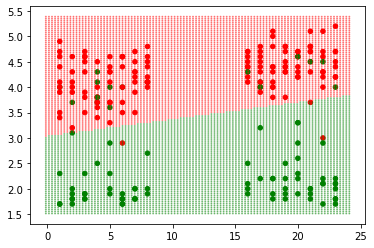

Best accuracy score for geyser.csv is 0.8558558558558559
kernel = polynomial
parameter = 2
C = 0.5


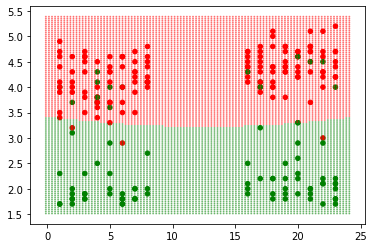

Best accuracy score for geyser.csv is 0.9054054054054054
kernel = gaussian
parameter = 1
C = 0.5


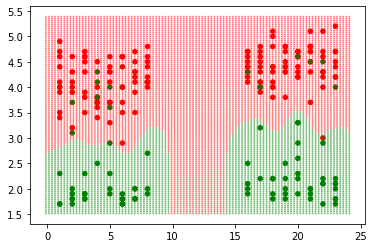

  0%|          | 0/8 [00:00<?, ?it/s]

Best accuracy score for chips.csv is 0.4830508474576271
kernel = linear
C = 0.1


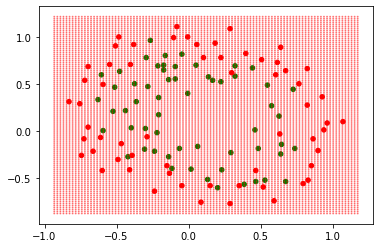

Best accuracy score for chips.csv is 0.8389830508474576
kernel = polynomial
parameter = 5
C = 0.1


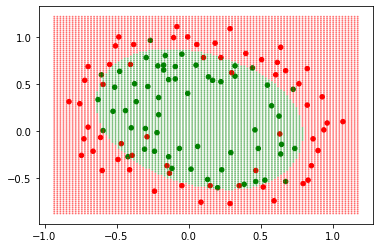

Best accuracy score for chips.csv is 0.8220338983050848
kernel = gaussian
parameter = 2
C = 50.0


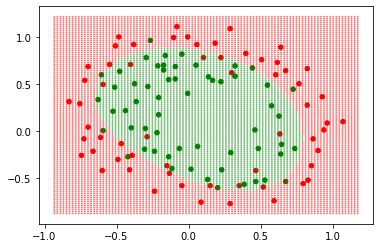

In [14]:
for filename in os.listdir('data'):
    X, y = read_data(filename)
    class_for_kernel = get_hyperparameters(X, y)
    
    for kernel, best_scores in class_for_kernel.items():
        print('Best accuracy score for {0} is {1}'.format(filename, best_scores[0]))
        draw_graphics(X, y, best_scores[1], kernel)